# Food Vision Big


In [2]:
# Check the GPU
# Google colab offers dreee Gpus but not all are compatible with mixed precision training
# Only those that are above 7.0 version computable like T4
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-20af100b-9eb1-2a37-51cb-4e128b9e9b5a)


In [3]:
# Getting the helper functions ...
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-11-14 11:04:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-11-14 11:04:30 (22.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [4]:
# Import The needed functions
from helper_functions import plot_loss_curves, compare_historys

# Using TensorFlow DataSet to get the needed data

In [5]:
# Import tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds

dataset_list = tfds.list_builders()

In [6]:
print("food101" in dataset_list) # he taget data set in list of TFDS data set

True


In [7]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train", "validation"],
                                             shuffle_files=False, # Weirdly the shuffle_files are also applied to the test data /:
                                             as_supervised=True, # data get's returned in touple format
                                             with_info = True)

In [8]:
# info
print(ds_info.splits["train"].num_examples)
print(ds_info.splits["validation"].num_examples)

75750
25250


#### In order to get a better undrestanding of the data:
1. Get the Class names
2. Shape of the inputs data (image tensors)
3. The datatype of the input data
4. The labels (One-hot encoded or label encoded?)
5. Do the labels match up with the class names?


In [9]:
# Visualize the data (features of food 101)
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
# Getting the classes names
class_names = ds_info.features["label"].names
class_names[:10] # Getting the first 10 class names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample of the train data
train_data_sample = train_data.take(1)
train_data_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [12]:
# Output info about training sample
for image, label in train_data_sample:
  print(f"""
  Image Shape: {image.shape},
  Image Dtype: {image.dtype},
  Target Class from Food 101 (tensor form) : {label},
  Class name (str) : {class_names[label.numpy()]}
  """)
  # as you'll see in the the Class names...
  #    since there's name it's not one hot encoded => We'll need to sparce_categorical_crossentropy


  Image Shape: (512, 512, 3),
  Image Dtype: <dtype: 'uint8'>,
  Target Class from Food 101 (tensor form) : 56,
  Class name (str) : huevos_rancheros
  


In [13]:
# IMage tensor:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [14]:
# The min and max value of the tensor
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

# Plotting some images to see them

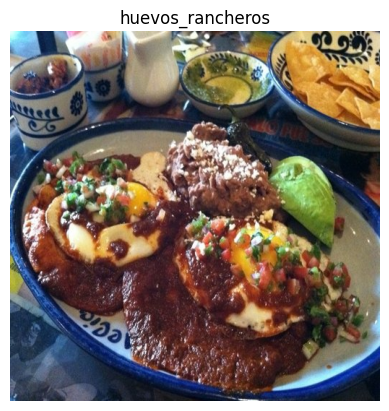

In [15]:
# plot an image tensor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


plt.imshow(image)
plt.title(class_names[label.numpy()]) # Adds title to the image to varify the label and image are associated
plt.axis(False);

## Creating preprocessing functions for data

We need our data batched and normalized etc. for better performance

In [16]:
import tensorflow as tf

def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' &
    reshapes image to [img_shape, img_shape, color_channels].
    """
    # Resize the image
    image = tf.image.resize(image, [img_shape, img_shape])
    image = tf.cast(image, tf.float32)

    return image, label

In [17]:
# Preprocess a single image to see the results for the made funcitons
preprocessed_img, preprocessed_label = preprocess_img(image, label)

print(f"Image before preprocessing: \n {image[:2]}..., \nShape: {image.shape}, \nDtype: {image.dtype}")
print(f"Image after preprocessing: \n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDtype: {preprocessed_img.dtype}")

Image before preprocessing: 
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3), 
Dtype: <dtype: 'uint8'>
Image after preprocessing: 
[[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3), 
Dtype: <dtype: 'float32'>


## Batch and prepare datasets


In [18]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [19]:
image.dtype

tf.uint8

In [20]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)


In [21]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> " Hey, Tensorflow Map this preprocessing function ('reprocess_img') arcoss our training, then shuffle a number of elements" and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.

In [59]:
# Getting the callbacks ready

!pip install wandb

import wandb
from wandb.integration.keras import WandbCallback

import wandb
from tensorflow.keras.callbacks import Callback

class CustomWandbCallback(Callback):
  def on_epoch_end(self, epoch, logs = None):
    if logs is not None:
      wandb.log(logs, step = epoch)

  def on_train_end(self, logs=None):
    wandb.finish()


# Model Checkpoint
checkpoint_path = "/content/model_checkpoint.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    verbose=0,
    monitor="val_accuracy",
    save_weights_only=True,
    save_best_only=True
)


In [23]:
# Setting up the mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy= "mixed_float16")

In [24]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [25]:
from tensorflow.keras import layers

# Creating base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = "Input_layer")
# In case the base model was mode EfficientNetB0 make sure to
#   use Rescaling since EfficientNetBX have them bu default...
# x = preprocessing.Rescaling(1./255)(x)

x = base_model(inputs, training=False) # Make sure layers which should be inference mode only stay like that
x = layers.GlobalAveragePooling2D(name = "2D_Pooling_layer")(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name = "softmax_float32_output")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [26]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2D_Pooling_layer                     │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32_output (Activation)  │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [27]:
# Checking the layers dtype for mixed precision policy
for n, layer in enumerate(model.layers):
  print(f"{n}: name: {layer.name},  Dtype: {layer.dtype},   Traible:{layer.trainable},  layer_policy: {layer.dtype_policy}")

0: name: Input_layer,  Dtype: float32,   Traible:True,  layer_policy: <DTypePolicy "mixed_float16">
1: name: efficientnetb0,  Dtype: float32,   Traible:False,  layer_policy: <DTypePolicy "mixed_float16">
2: name: 2D_Pooling_layer,  Dtype: float32,   Traible:True,  layer_policy: <DTypePolicy "mixed_float16">
3: name: dense,  Dtype: float32,   Traible:True,  layer_policy: <DTypePolicy "mixed_float16">
4: name: softmax_float32_output,  Dtype: float32,   Traible:True,  layer_policy: <DTypePolicy "float32">


In [28]:
# EfficientNetB0 layers checked:
for n, layer in enumerate(model.layers[1].layers[:20]):
  print(n, layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

0 input_layer float32 False <DTypePolicy "mixed_float16">
1 rescaling float32 False <DTypePolicy "mixed_float16">
2 normalization float32 False <DTypePolicy "mixed_float16">
3 rescaling_1 float32 False <DTypePolicy "mixed_float16">
4 stem_conv_pad float32 False <DTypePolicy "mixed_float16">
5 stem_conv float32 False <DTypePolicy "mixed_float16">
6 stem_bn float32 False <DTypePolicy "mixed_float16">
7 stem_activation float32 False <DTypePolicy "mixed_float16">
8 block1a_dwconv float32 False <DTypePolicy "mixed_float16">
9 block1a_bn float32 False <DTypePolicy "mixed_float16">
10 block1a_activation float32 False <DTypePolicy "mixed_float16">
11 block1a_se_squeeze float32 False <DTypePolicy "mixed_float16">
12 block1a_se_reshape float32 False <DTypePolicy "mixed_float16">
13 block1a_se_reduce float32 False <DTypePolicy "mixed_float16">
14 block1a_se_expand float32 False <DTypePolicy "mixed_float16">
15 block1a_se_excite float32 False <DTypePolicy "mixed_float16">
16 block1a_project_conv f

In [29]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Fit the model
As Usual... first train the feature extraction model so the last layer get a grasp of the whole data Then Unfroze some data and Fine Tune it
|
1. Feature extraction Training
2. Fine Tune


In [ ]:
# Setting the wandb
wandb.init(project="Mini_Food_101_project", name = "Feature_extraction_run")

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks = [model_checkpoint, CustomWandbCallback()])
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 234s 84ms/step - accuracy: 0.4346 - loss: 2.4542 - val_accuracy: 0.6634 - val_loss: 1.2916
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 223s 76ms/step - accuracy: 0.6280 - loss: 1.4544 - val_accuracy: 0.6793 - val_loss: 1.2065
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 179s 75ms/step - accuracy: 0.6685 - loss: 1.2874 - val_accuracy: 0.6814 - val_loss: 1.1626


accuracy,▁▆█
loss,█▃▁
val_accuracy,▁▇█
val_loss,█▃▁
accuracy,0.6671
loss,1.28478
val_accuracy,0.68141
val_loss,1.16256


In [ ]:
# Save the model
save_path = "/content/featureExtractedModel.h5"
model.save(save_path, save_format = "h5")

In [30]:
# Load The saved trained model which reached 69% accuracy
loaded_101_model = tf.keras.models.load_model("/content/featureExtractedModel.h5")

In [31]:
# Check the model to make sure the Model is uploaded correctly
loaded_101_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2D_Pooling_layer                     │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32_output (Activation)  │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,958 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 6 (36.00 B)

In [32]:
# As always evaluate and remember that the main model and this
#   model are the same with close resutls not the same
results_loaded_101_model = loaded_101_model.evaluate(test_data)
results_loaded_101_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 98s 78ms/step - accuracy: 0.6872 - loss: 1.1551


[1.1497669219970703, 0.6908515095710754]

In [33]:
# Unfreezing some layers For Fine Tune
for n, layer in enumerate(loaded_101_model.layers):
  layer.trainable = True # Set all the layers trainablity yo True
  print(layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

Input_layer float32 <DTypePolicy "mixed_float16"> True
efficientnetb0 float32 <DTypePolicy "mixed_float16"> True
2D_Pooling_layer float32 <DTypePolicy "mixed_float16"> True
dense_1 float32 <DTypePolicy "mixed_float16"> True
softmax_float32_output float32 <DTypePolicy "float32"> True


In [34]:
# Freez all the layers in the backbone(EfficientNetB0) except the last 20
loaded_101_model.layers[1].trainable = False
for n, layer in enumerate(loaded_101_model.layers[1].layers[-20:]):
  layer.trainable = True

In [35]:
for n, layer in enumerate(loaded_101_model.layers[1].layers[-25:]):
  print(n, layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

0 block6d_se_squeeze float32 <DTypePolicy "mixed_float16"> False
1 block6d_se_reshape float32 <DTypePolicy "mixed_float16"> False
2 block6d_se_reduce float32 <DTypePolicy "mixed_float16"> False
3 block6d_se_expand float32 <DTypePolicy "mixed_float16"> False
4 block6d_se_excite float32 <DTypePolicy "mixed_float16"> False
5 block6d_project_conv float32 <DTypePolicy "mixed_float16"> True
6 block6d_project_bn float32 <DTypePolicy "mixed_float16"> True
7 block6d_drop float32 <DTypePolicy "mixed_float16"> True
8 block6d_add float32 <DTypePolicy "mixed_float16"> True
9 block7a_expand_conv float32 <DTypePolicy "mixed_float16"> True
10 block7a_expand_bn float32 <DTypePolicy "mixed_float16"> True
11 block7a_expand_activation float32 <DTypePolicy "mixed_float16"> True
12 block7a_dwconv float32 <DTypePolicy "mixed_float16"> True
13 block7a_bn float32 <DTypePolicy "mixed_float16"> True
14 block7a_activation float32 <DTypePolicy "mixed_float16"> True
15 block7a_se_squeeze float32 <DTypePolicy "mixed

In [36]:
# Making more callbacks
# Early Stopping

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 3,
                                                  monitor="val_loss")

# New Checkpoint
checkpoint_path = "/content/Model_Checkpoint.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = "val_loss",
                                                      save_best_only = True)

# reduceLRPlateau for reducing the learning rate when metric stops imporoving

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor = 0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr = 1e-7) # Deafault is 1e-3 ot 1e-4


In [37]:
# Recompiling the model
loaded_101_model.compile(loss = "sparse_categorical_crossentropy",
                         optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # Lowering the learning rate for fine tune is a must
                         metrics = ["accuracy"])


In [79]:
# Getting the Wandb Ready to Track...
wandb.init(project = "Mini_Food_101_project", name = "Fine_tune_run")

# Fitting the model to Fine tune
history_101_class_fine_tuned= loaded_101_model.fit(train_data,
                                                   initial_epoch = history_101_food_classes_feature_extract.epoch[-1], # Starting from the last epoch it trained on
                                                   epochs= 20,
                                                   # I don't add steps_per_epoch to avoid the error of not enoug data
                                                   validation_data = test_data,
                                                   validation_steps= int(0.15 * len(test_data)),
                                                   callbacks=[CustomWandbCallback(), model_checkpoint,
                                                              reduce_lr, early_stopping])

Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 227s 85ms/step - accuracy: 0.6362 - loss: 1.4149 - val_accuracy: 0.7307 - val_loss: 0.9886 - learning_rate: 1.0000e-04
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 274s 94ms/step - accuracy: 0.7310 - loss: 1.0122 - val_accuracy: 0.7405 - val_loss: 0.9451 - learning_rate: 1.0000e-04
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 190s 79ms/step - accuracy: 0.7664 - loss: 0.8809 - val_accuracy: 0.7553 - val_loss: 0.8956 - learning_rate: 1.0000e-04
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 185s 77ms/step - accuracy: 0.7971 - loss: 0.7705 - val_accuracy: 0.7672 - val_loss: 0.8589 - learning_rate: 1.0000e-04
Epoch 7/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 187s 78ms/step - accuracy: 0.8198 - loss: 0.6780 - val_accuracy: 0.7677 - val_loss: 0.8615 - learning_rate: 1.0000e-04
Epoch 8/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 77ms/step - accuracy: 0.8432 - loss: 0.6023 - val_accuracy: 0.7707 - val_loss: 0.8450 - learning_rate: 1.0000e-04
Epoch 9/20
2368/2368 ━━━━━━━━━━━━━

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8756 - loss: 0.4788
Epoch 10: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 76ms/step - accuracy: 0.8756 - loss: 0.4788 - val_accuracy: 0.7667 - val_loss: 0.8674 - learning_rate: 1.0000e-04
Epoch 11/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 187s 78ms/step - accuracy: 0.9011 - loss: 0.3975 - val_accuracy: 0.7640 - val_loss: 0.8597 - learning_rate: 2.0000e-05


accuracy,▁▃▄▅▅▆▇▇█
loss,█▆▅▄▃▃▂▂▁
val_accuracy,▁▃▅▇▇█▄▇▇
val_loss,█▆▃▂▂▁▄▂▂
accuracy,0.90554
loss,0.38824
val_accuracy,0.76404
val_loss,0.85968


In [81]:
# Save the model in SavedModel format
saving_path_fine_tuned = "/content/Fine_tuned_101_Food_model.keras"
loaded_101_model.save(saving_path_fine_tuned)
# Since there are objects to this model now ... we can't save the model as in keras format
# So we use the Tensorflow format

In [40]:
# Let's evaluate the Fine Tuned model on the whole test_data:
loaded_fine_tuned_model = tf.keras.models.load_model("/content/Fine_tuned_101_Food_model.keras")
resutls_fine_tuned_model = loaded_fine_tuned_model.evaluate(test_data)
resutls_fine_tuned_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 69ms/step - accuracy: 0.7628 - loss: 0.8880


[0.8879608511924744, 0.760792076587677]

# Visualizing the performance of the model

In [41]:
preds_probs = loaded_fine_tuned_model.predict(test_data, verbose = 1)

preds_probs

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step


array([[9.76290554e-03, 4.73375949e-05, 4.09672721e-05, ...,
        1.49581989e-03, 3.71556998e-05, 1.31832100e-02],
       [2.27884311e-06, 1.24608050e-07, 5.43391138e-07, ...,
        5.24619509e-07, 1.08082368e-05, 6.61788278e-08],
       [4.62835214e-06, 1.69556606e-05, 4.49911386e-06, ...,
        2.70233159e-06, 9.83176869e-06, 7.94140817e-07],
       ...,
       [9.81528983e-02, 1.72497457e-05, 1.48078144e-07, ...,
        1.82193635e-05, 4.08241904e-04, 2.23294925e-03],
       [1.13228034e-05, 1.09054366e-08, 1.12642880e-07, ...,
        2.10176387e-09, 7.22214555e-09, 3.58678136e-07],
       [5.10990758e-05, 1.69026505e-04, 5.06938568e-06, ...,
        1.30358705e-04, 1.15344233e-06, 3.69438203e-06]], dtype=float32)

In [42]:
import numpy as np
preds_probs.shape

(25250, 101)

In [43]:
# What does the first predictions probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([9.7629055e-03, 4.7337595e-05, 4.0967272e-05, 4.7522866e-05,
        2.0086183e-04, 1.4298984e-04, 1.7279006e-05, 2.4754726e-04,
        2.4859037e-02, 4.3361133e-04, 1.0751359e-04, 1.3428642e-06,
        7.8058150e-04, 9.7892233e-05, 5.5998676e-03, 4.2676133e-06,
        8.7306043e-03, 5.9363376e-03, 7.6514095e-07, 9.1602720e-05,
        1.4953734e-05, 5.3630346e-03, 6.9470634e-03, 4.8467403e-04,
        3.3496881e-06, 2.2890965e-05, 4.5346638e-05, 7.4629224e-04,
        2.3899565e-04, 2.5601926e-01, 3.7936876e-03, 1.5280762e-04,
        3.9397841e-05, 1.7377954e-06, 1.5972022e-02, 2.0316886e-06,
        1.1051048e-03, 1.2890924e-05, 1.1092644e-04, 3.6153491e-05,
        5.4583606e-06, 2.1336726e-05, 1.2815094e-02, 1.6944801e-05,
        1.2252651e-05, 4.4409293e-01, 6.3929917e-07, 2.1291914e-06,
        8.9131892e-05, 1.8362999e-03, 2.9507619e-05, 1.9386507e-06,
        3.7740818e-05, 9.3606021e-04, 8.0669342e-06, 2.3617604e-05,
        5.3335103e-04, 1.1136059e-04, 2.4617456e

In [44]:
# We get one prediction probabilty per calss (in our case there's 101 predictions probabilities)
print(f"Number of predictions for sample 0: {len(preds_probs[0])}")
print(f"What predictions probabulty sample 0 looks like?:\n {preds_probs[0]}")
print(f"The class with the highest prediced probabilty by the model for sample 0 : {preds_probs[0].argmax()}")

Number of predictions for sample 0: 101
What predictions probabulty sample 0 looks like?:
 [9.7629055e-03 4.7337595e-05 4.0967272e-05 4.7522866e-05 2.0086183e-04
 1.4298984e-04 1.7279006e-05 2.4754726e-04 2.4859037e-02 4.3361133e-04
 1.0751359e-04 1.3428642e-06 7.8058150e-04 9.7892233e-05 5.5998676e-03
 4.2676133e-06 8.7306043e-03 5.9363376e-03 7.6514095e-07 9.1602720e-05
 1.4953734e-05 5.3630346e-03 6.9470634e-03 4.8467403e-04 3.3496881e-06
 2.2890965e-05 4.5346638e-05 7.4629224e-04 2.3899565e-04 2.5601926e-01
 3.7936876e-03 1.5280762e-04 3.9397841e-05 1.7377954e-06 1.5972022e-02
 2.0316886e-06 1.1051048e-03 1.2890924e-05 1.1092644e-04 3.6153491e-05
 5.4583606e-06 2.1336726e-05 1.2815094e-02 1.6944801e-05 1.2252651e-05
 4.4409293e-01 6.3929917e-07 2.1291914e-06 8.9131892e-05 1.8362999e-03
 2.9507619e-05 1.9386507e-06 3.7740818e-05 9.3606021e-04 8.0669342e-06
 2.3617604e-05 5.3335103e-04 1.1136059e-04 2.4617456e-02 1.7619805e-05
 8.0814993e-07 1.2516870e-06 2.8377199e-05 5.8331357e-06 

In [45]:
import numpy as np

# extract true labels from test_data
# Generate predictions using the model
y_true = []
y_pred = []

for images, label in test_data:

    y_true.extend(label.numpy())

    preds = loaded_fine_tuned_model.predict(images, verbose = 0)
    y_pred.extend(np.argmax(preds, axis=1))

print("y_true:", y_true[:10])
print("y_pred:", y_pred[:10])

y_true: [29, 81, 91, 53, 97, 97, 10, 31, 3, 100]
y_pred: [45, 81, 91, 53, 97, 97, 10, 31, 3, 100]


In [46]:
# Making the confusion Metrix
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()


  ### Changed (plot x-labels vertically)
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [47]:
make_confusion_matrix(y_true = y_true, y_pred = y_pred,
                      classes = class_names,
                      figsize = (100, 100),
                      text_size = (20),
                      savefig = True)